In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
torch.cuda.is_available()

True

In [2]:
DATA_PATH = "data/kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DATA_PATH, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [3]:
"""
Data directory for the masks and images
Format is TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Each image is a slice MRI scan of the patient's brain, with a mask showing tumor area if present
"""
masks[:5], images[:5]

(['TCGA_HT_7690_19960312_19_mask.tif',
  'TCGA_HT_7690_19960312_15_mask.tif',
  'TCGA_HT_7690_19960312_3_mask.tif',
  'TCGA_HT_7690_19960312_17_mask.tif',
  'TCGA_HT_7690_19960312_18_mask.tif'],
 ['TCGA_HT_7690_19960312_19.tif',
  'TCGA_HT_7690_19960312_15.tif',
  'TCGA_HT_7690_19960312_3.tif',
  'TCGA_HT_7690_19960312_17.tif',
  'TCGA_HT_7690_19960312_18.tif'])

In [4]:
# Amount of data we are dealing with
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [5]:
# Create dataframe of each image location
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})
imagePath_df['image-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['masks']
imagePath_df.head()

,directory,images,masks,image-path,mask-path
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_19.tif,TCGA_HT_7690_19960312_19_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_15.tif,TCGA_HT_7690_19960312_15_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_3.tif,TCGA_HT_7690_19960312_3_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...


In [6]:
# Show image shape
imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['images'].iloc[0])
maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['masks'].iloc[0])
image = cv2.imread(imagePath)
mask = cv2.imread(maskPath)

image.shape, mask.shape

((256, 256, 3), (256, 256, 3))

In [7]:
def plot_image(i):

    imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['images'].iloc[i])
    maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['masks'].iloc[i])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.4)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

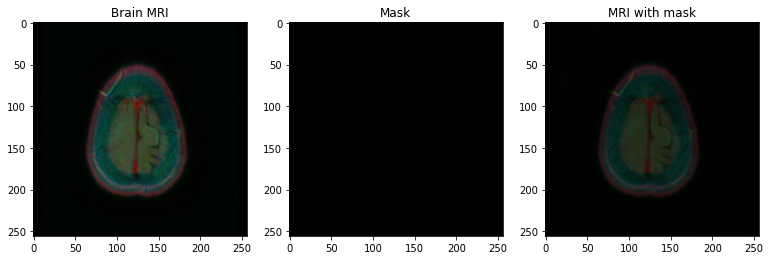

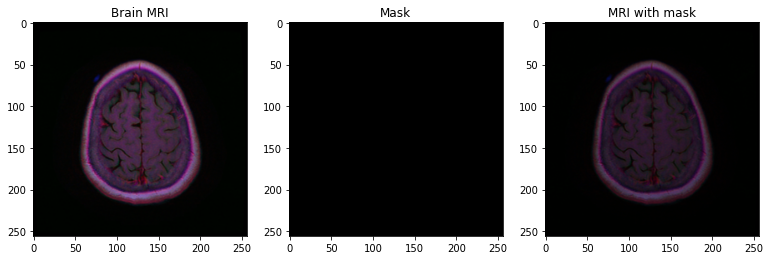

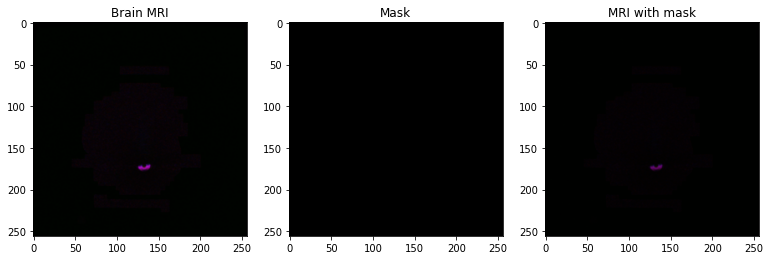

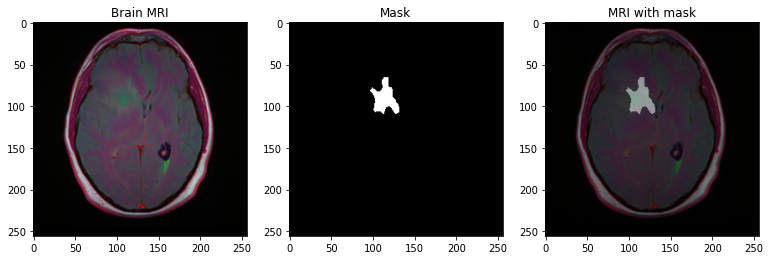

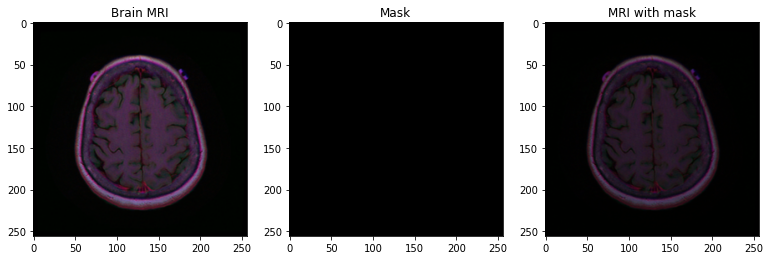

In [8]:
for i in range(5):
    plot_image(random.randint(0,len(imagePath)))

In [9]:
train , test = train_test_split(imagePath_df, test_size=0.2)

In [10]:
# Training samples vs testing samples
len(train), len(test)

(3143, 786)

Now we move on to defining the neural network

In [11]:
# First define the double convolution layer for u-net down
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias =False), # Kernel 3, Stride 1, Same Output
            nn.BatchNorm2d(out_channels), # not in original paper, but a follow up paper had this layer
            nn.ReLu(inplace=True),
            
            # Second conv layer
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias =False), # Kernel 3, Stride 1, Same Output
            nn.BatchNorm2d(out_channels), # not in original paper, but a follow up paper had this layer
            nn.ReLu(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

In [12]:
class UNET(nn.Module):
    def __init__(
        self, 
        in_channels=3, 
        out_channels=1, 
        features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)